In [114]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import matplotlib.pyplot as plt

import geocoder # import geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from bs4 import BeautifulSoup   # library to scrap web pages
import lxml # library to parse html

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()

print('Libraries imported.')


Libraries imported.


## 1. Load the dataset and do some EDA

In [115]:
df_pincode = pd.read_csv(r"Pincode_30052019.csv",encoding="latin-1")

In [116]:
df_pincode = df_pincode[["Pincode","Division Name","Office Name"]]

In [117]:
df_pincode.head()

,Pincode,Division Name,Office Name
0,515004,Anantapur Division,A Narayanapuram B.O
1,515731,Anantapur Division,Akuledu B.O
2,515002,Anantapur Division,Alamuru B.O
3,515766,Anantapur Division,Allapuram B.O
4,515415,Anantapur Division,Aluru B.O


In [118]:
df_pincode.isnull().sum()

Pincode          0
Division Name    0
Office Name      0
dtype: int64

In [119]:
df_pincode.dropna(inplace=True)
df_pincode.isnull().sum()

Pincode          0
Division Name    0
Office Name      0
dtype: int64

In [120]:
df_cities = df_pincode[df_pincode['Division Name'].str.contains('Mumbai',case=False,regex=True)].reset_index().drop(columns='index',axis=1)

In [121]:
df_cities.head()

,Pincode,Division Name,Office Name
0,400037,Mumbai City East Division,Antop Hill S.O
1,400037,Mumbai City East Division,B P T Colony S.O
2,400003,Mumbai City East Division,B.P.Lane S.O
3,400012,Mumbai City East Division,BEST STaff Quarters S.O
4,400037,Mumbai City East Division,C G S Colony S.O


In [122]:
df_cities.tail()

,Pincode,Division Name,Office Name
361,410203,Navi Mumbai Division,Vavoshi B.O
362,410201,Navi Mumbai Division,Vengaon B.O
363,410206,Navi Mumbai Division,Wavandhal B.O
364,410206,Navi Mumbai Division,Wavarle B.O
365,410208,Navi Mumbai Division,Wawanje B.O


In [123]:
df_cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 3 columns):
Pincode          366 non-null int64
Division Name    366 non-null object
Office Name      366 non-null object
dtypes: int64(1), object(2)
memory usage: 8.7+ KB


In [124]:
df_cities.shape

(366, 3)

In [125]:
# define the dataframe columns
column_names = ['PostalCode', 'Borough', 'Neighborhood'] 
df_cities.columns = column_names

In [126]:
df_cities.head()

,PostalCode,Borough,Neighborhood
0,400037,Mumbai City East Division,Antop Hill S.O
1,400037,Mumbai City East Division,B P T Colony S.O
2,400003,Mumbai City East Division,B.P.Lane S.O
3,400012,Mumbai City East Division,BEST STaff Quarters S.O
4,400037,Mumbai City East Division,C G S Colony S.O


In [127]:
df_postal = df_cities.groupby(['PostalCode','Borough'])['Neighborhood'].apply(','.join).reset_index()

In [128]:
df_postal.head()

,PostalCode,Borough,Neighborhood
0,400001,Mumbai City South Division,"Bazargate SO,MPT SO,Stock Exchange SO,Tajmahal..."
1,400001,Mumbai GPO Division,Mumbai GPO
2,400002,Mumbai City South Division,"Kalbadevi H.O,S. C. Court S.O,Thakurdwar S.O"
3,400003,Mumbai City East Division,"B.P.Lane S.O,Mandvi S.O (Mumbai),Masjid S.O,Nu..."
4,400004,Mumbai City South Division,"Ambewadi S.O (Mumbai),Charni Road S.O,Chaupati..."


In [129]:
df_postal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 3 columns):
PostalCode      116 non-null int64
Borough         116 non-null object
Neighborhood    116 non-null object
dtypes: int64(1), object(2)
memory usage: 2.8+ KB


In [130]:
df_postal['PostalCode'] = df_postal['PostalCode'].astype('object')
df_postal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 3 columns):
PostalCode      116 non-null object
Borough         116 non-null object
Neighborhood    116 non-null object
dtypes: object(3)
memory usage: 2.8+ KB


## 2. Get the location co-ordinates using the opencage API

In [132]:
from opencage.geocoder import OpenCageGeocode
def get_location(postal_code):
    key = 'ca74e228b71742c7b7e5696f103520ad'  # get api key from:  https://opencagedata.com
    geocoder = OpenCageGeocode(key)
    query = ("{},India".format(postal_code))
    results = geocoder.geocode(query)   
    lat = results[0]['geometry']['lat']
    long = results[0]['geometry']['lng']
    return [lat,long]

In [133]:
df_postal['Location']= df_postal.progress_apply(lambda x: get_location(x['PostalCode']),axis=1)
df_postal[['Latitude','Longitude']] = pd.DataFrame(df_postal.Location.values.tolist(), index= df_postal.index)
df_postal.drop(columns='Location',inplace=True)
df_postal.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,400001,Mumbai City South Division,"Bazargate SO,MPT SO,Stock Exchange SO,Tajmahal...",18.910875,72.819470
1,400001,Mumbai GPO Division,Mumbai GPO,18.910875,72.819470
2,400002,Mumbai City South Division,"Kalbadevi H.O,S. C. Court S.O,Thakurdwar S.O",18.949540,72.826180
3,400003,Mumbai City East Division,"B.P.Lane S.O,Mandvi S.O (Mumbai),Masjid S.O,Nu...",18.951606,72.834797
4,400004,Mumbai City South Division,"Ambewadi S.O (Mumbai),Charni Road S.O,Chaupati...",18.962419,72.827092


In [134]:
df_coordinates_mumbai = df_postal[['PostalCode','Latitude','Longitude']]

In [135]:
df_coordinates_mumbai.to_csv("co-ordinates_mumbai.csv")

In [136]:
df_postal.to_csv("decoded.csv")

In [137]:
address = 'Mumbai, India'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
lat_mumbai = location.latitude
long_mumbai = location.longitude
print('The geograpical coordinate of Mumbai City are {}, {}.'.format(lat_mumbai, long_mumbai))

The geograpical coordinate of Mumbai City are 18.9387711, 72.8353355.


In [138]:
# geograpical coordinate of Mumbai City
# lat_mumbai=18.9387711
# long_mumbai=72.8353355

# create map of New York using latitude and longitude values
map_mumbai = folium.Map(location=[lat_mumbai, long_mumbai], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_postal['Latitude'], df_postal['Longitude'],\
                                           df_postal['Borough'], df_postal['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mumbai)  
    
map_mumbai

## 3. Explore Neighborhoods in Mumbai

In [139]:
from datetime import date
today = date.today()
VERSION = today.strftime("%Y%m%d")
CLIENT_ID = 'BOEXNJGAKW1OP2ZUWBN0ZBKQL3NNMK1Z2QQOD1QICYBPJZIJ' # your Foursquare ID
CLIENT_SECRET = '0LOK3GKOOHUUBAGBBRGGXJQ2FJ34J2URTZCHELGYA4ZEHWHE' # your Foursquare Secret
#VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
print("VERSION:", VERSION)

Your credentails:
CLIENT_ID: BOEXNJGAKW1OP2ZUWBN0ZBKQL3NNMK1Z2QQOD1QICYBPJZIJ
CLIENT_SECRET:0LOK3GKOOHUUBAGBBRGGXJQ2FJ34J2URTZCHELGYA4ZEHWHE
VERSION: 20200103


let's borrow the get_category_type function from the Foursquare lab.

In [140]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [141]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [142]:
df_postal

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,400001,Mumbai City South Division,"Bazargate SO,MPT SO,Stock Exchange SO,Tajmahal...",18.910875,72.819470
1,400001,Mumbai GPO Division,Mumbai GPO,18.910875,72.819470
2,400002,Mumbai City South Division,"Kalbadevi H.O,S. C. Court S.O,Thakurdwar S.O",18.949540,72.826180
3,400003,Mumbai City East Division,"B.P.Lane S.O,Mandvi S.O (Mumbai),Masjid S.O,Nu...",18.951606,72.834797
4,400004,Mumbai City South Division,"Ambewadi S.O (Mumbai),Charni Road S.O,Chaupati...",18.962419,72.827092
5,400005,Mumbai City South Division,"Asvini SO,Colaba Bazar SO,Colaba SO,Holiday Ca...",18.914311,72.817355
6,400006,Mumbai City West Division,Malabar Hill S.O,18.949223,72.798232
7,400007,Mumbai City West Division,"Bharat Nagar S.O (Mumbai),Grant Road S.O,N.S.P...",18.965878,72.815000
8,400008,Mumbai City West Division,"Falkland Road S.O,J.J.Hospital S.O,Kamathipura...",18.974045,72.836670
9,400009,Mumbai City East Division,"CHINCHBUNDER S.O,Noor Baug S.O,Princess Dock S.O",18.959669,72.838548


let's simplify the above map and segment and cluster only the neighborhoods in Navi Mumbai . So let's slice the original dataframe and create a new dataframe of the Navi Mumbai data.

In [143]:
navi_mumbai_data = df_postal[df_postal['Borough'] == 'Navi Mumbai Division'].reset_index(drop=True)
navi_mumbai_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,400614,Navi Mumbai Division,"Belapur Node III S.O,Belapur Node V S.O,Kon...",19.021116,73.038971
1,400701,Navi Mumbai Division,Ghansoli S.O,19.126158,73.001978
2,400702,Navi Mumbai Division,"Bokadvira B.O,Chanje B.O,Karanja B.O,Kegaon B....",18.882280,72.949381
3,400703,Navi Mumbai Division,"K.U.Bazar S.O,Turbhe Market S.O,Turbhe S.O,Vas...",19.077091,73.000022
4,400704,Navi Mumbai Division,"Mora B.O,N.S.Karanja S.O",18.908600,72.929900


Let's get the geographical coordinates of Navi Mumbai.

In [144]:
address = 'Navi Mumbai, Mumbai, India'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Navi Mumbai are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Navi Mumbai are 19.0500068, 73.075871.


In [146]:
# create map of Navi Mumbai using latitude and longitude values
map_navi_mumbai = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(navi_mumbai_data['Latitude'], navi_mumbai_data['Longitude'], navi_mumbai_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_navi_mumbai)  
    
map_navi_mumbai

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *navi_mumbai_venues*.

In [147]:
navi_mumbai_venues = getNearbyVenues(names=navi_mumbai_data['Neighborhood'],
                                   latitudes=navi_mumbai_data['Latitude'],
                                   longitudes=navi_mumbai_data['Longitude']
                                    )

Belapur Node   III S.O,Belapur Node  V S.O,Konkan Bhavan S.O
Ghansoli S.O
Bokadvira B.O,Chanje B.O,Karanja B.O,Kegaon B.O,ONGC dronagiri B.O,Sheva B.O,Uran S.O
K.U.Bazar S.O,Turbhe Market S.O,Turbhe S.O,Vashi S.O (Thane),Vashi Sec 26 S.O,Vashi VII S.O
Mora B.O,N.S.Karanja S.O
Sanpada S.O
Darave B.O,Nerul Node II S.O,Nerul Node III S.O,Nerul Sec 48 S.O
Jaskhar B.O,Jnpt S.O,Navghar B.O
Airoli B.O,Airoli S.O
Kopar Khairne S.O
Millenium Business Park S.O
Borgaon B.O,Dahivali T.Varedi B.O,Kalamb B.O,Mangaon T.Varedi B.O,Manivali B.O,Neral S.O,Pashane B.O,Poshir B.O,Shelu B.O,Vakas B.O
Matheran S.O
Ambivali B.O,Beed Budruk B.O,Bhivpuri Camp B.O,Chinchwali B.O,Dahivali T.Need B.O,Gaulwadi B.O,Gaurkamath B.O,Gundge B.O,Humgaon B.O,Jambrung B.O,Kadav B.O,Karjat S.O (Raigarh(MH)),Kashele B.O,Khandas B.O,Kirwali B.O,Kondivade B.O,Koshane B.O,Mandavane B.O,Nandgaon B.O,Nasarapur B.O,Palasdari B.O,Pathraj B.O,Salokh T.Need B.O,Sugawe B.O,Tiware B.O,Vengaon B.O
Khalapur S.O,Savroli B.O
Donwat B.O,Kh

In [148]:
print(navi_mumbai_venues.shape)
navi_mumbai_venues.head()

(81, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Belapur Node III S.O,Belapur Node V S.O,Kon...",19.021116,73.038971,McDonald's,19.024715,73.041269,Fast Food Restaurant
1,"Belapur Node III S.O,Belapur Node V S.O,Kon...",19.021116,73.038971,CBD Belapur Railway Station,19.018517,73.039366,Train Station
2,"Belapur Node III S.O,Belapur Node V S.O,Kon...",19.021116,73.038971,Sai Sanjog Fast Food,19.019850,73.037141,Fast Food Restaurant
3,"Belapur Node III S.O,Belapur Node V S.O,Kon...",19.021116,73.038971,Belapur Railway Station,19.018253,73.039280,Train Station
4,"Belapur Node III S.O,Belapur Node V S.O,Kon...",19.021116,73.038971,Flames,19.024637,73.038253,Indian Restaurant


In [149]:
navi_mumbai_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adai B.O,Awre B.O,Chawk B.O,Chirner B.O,Dighode B.O,GAVHAN,Jasai B.O,Jci Kamothe B.O,Jui B.O,KAMOTHE S.O,Kelevane B.O,Khanda Colony S.O,Koproli B.O,Kundevahal B.O,Lodhivali B.O,Morbe B.O,Nere B.O,Nhava B.O,Panvel City S.O,Panvel H.O,PARGAON B.O,Somatane B.O,Ulwa B.O,VAHAL B.O,Vaje B.O,Vasheni B.O,Wavandhal B.O,Wavarle B.O",4,4,4,4,4,4
"Airoli B.O,Airoli S.O",1,1,1,1,1,1
"Belapur Node III S.O,Belapur Node V S.O,Konkan Bhavan S.O",9,9,9,9,9,9
"Bokadvira B.O,Chanje B.O,Karanja B.O,Kegaon B.O,ONGC dronagiri B.O,Sheva B.O,Uran S.O",1,1,1,1,1,1
"Darave B.O,Nerul Node II S.O,Nerul Node III S.O,Nerul Sec 48 S.O",9,9,9,9,9,9
"Devichapada B.O,Koynavale B.O,Navde B.O,Padghe B.O,Taloja A.V. S.O,Taloja B.O,Tondra B.O,Wawanje B.O",1,1,1,1,1,1
"Donwat B.O,Khambewadi B.O,Khopoli S.O,Sajgaon B.O,Shilphata S.O,Vavoshi B.O",6,6,6,6,6,6
Ghansoli S.O,4,4,4,4,4,4
"K.U.Bazar S.O,Turbhe Market S.O,Turbhe S.O,Vashi S.O (Thane),Vashi Sec 26 S.O,Vashi VII S.O",13,13,13,13,13,13


In [150]:
print('There are {} uniques categories.'.format(len(navi_mumbai_venues['Venue Category'].unique())))

There are 45 uniques categories.


## 4. Analyze Each Neighborhood

In [151]:
# one hot encoding
navi_mumbai_onehot = pd.get_dummies(navi_mumbai_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
navi_mumbai_onehot['Neighborhood'] = navi_mumbai_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [navi_mumbai_onehot.columns[-1]] + list(navi_mumbai_onehot.columns[:-1])
navi_mumbai_onehot = navi_mumbai_onehot[fixed_columns]

navi_mumbai_onehot.head()

,Neighborhood,ATM,Asian Restaurant,BBQ Joint,Bar,Bed & Breakfast,Bistro,Breakfast Spot,Bus Station,Café,Chinese Restaurant,Cocktail Bar,Coffee Shop,Department Store,Dessert Shop,Diner,Electronics Store,English Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Food Court,Food Truck,Grocery Store,Gym,Hotel,Ice Cream Shop,Indian Restaurant,Juice Bar,Lounge,Market,Middle Eastern Restaurant,Mountain,Movie Theater,North Indian Restaurant,Pizza Place,Restaurant,Sandwich Place,Smoke Shop,Snack Place,Thai Restaurant,Theater,Toll Plaza,Train Station,Vegetarian / Vegan Restaurant
0,"Belapur Node III S.O,Belapur Node V S.O,Kon...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Belapur Node III S.O,Belapur Node V S.O,Kon...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,"Belapur Node III S.O,Belapur Node V S.O,Kon...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Belapur Node III S.O,Belapur Node V S.O,Kon...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,"Belapur Node III S.O,Belapur Node V S.O,Kon...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [152]:
navi_mumbai_onehot.shape

(81, 46)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [153]:
navi_mumbai_grouped = navi_mumbai_onehot.groupby('Neighborhood').mean().reset_index()
navi_mumbai_grouped

,Neighborhood,ATM,Asian Restaurant,BBQ Joint,Bar,Bed & Breakfast,Bistro,Breakfast Spot,Bus Station,Café,Chinese Restaurant,Cocktail Bar,Coffee Shop,Department Store,Dessert Shop,Diner,Electronics Store,English Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Food Court,Food Truck,Grocery Store,Gym,Hotel,Ice Cream Shop,Indian Restaurant,Juice Bar,Lounge,Market,Middle Eastern Restaurant,Mountain,Movie Theater,North Indian Restaurant,Pizza Place,Restaurant,Sandwich Place,Smoke Shop,Snack Place,Thai Restaurant,Theater,Toll Plaza,Train Station,Vegetarian / Vegan Restaurant
0,"Adai B.O,Awre B.O,Chawk B.O,Chirner B.O,Dighod...",0.0,0.25,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.00,0.25,0.000000,0.000000,0.00,0.0,0.000000,0.25,0.000000,0.00,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.000,0.000000,0.00,0.000000,0.000000
1,"Airoli B.O,Airoli S.O",0.0,0.00,0.000000,0.000000,0.000000,1.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.00,0.000000,0.00,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000,0.000000,0.00,0.000000,0.000000
2,"Belapur Node III S.O,Belapur Node V S.O,Kon...",0.0,0.00,0.111111,0.000000,0.111111,0.0,0.00,0.111111,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.333333,0.00,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.00,0.111111,0.00,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000,0.000000,0.00,0.222222,0.000000
3,"Bokadvira B.O,Chanje B.O,Karanja B.O,Kegaon B....",1.0,0.00,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.00,0.000000,0.00,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000,0.000000,0.00,0.000000,0.000000
4,"Darave B.O,Nerul Node II S.O,Nerul Node III S....",0.0,0.00,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.222222,0.000000,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.111111,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.00,0.111111,0.00,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.222222,0.000000,0.111111,0.000000,0.00,0.000,0.000000,0.00,0.111111,0.111111
5,"Devichapada B.O,Koynavale B.O,Navde B.O,Padghe...",0.0,0.00,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.0,1.000000,0.00,0.000000,0.00,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000,0.000000,0.00,0.000000,0.000000
6,"Donwat B.O,Khambewadi B.O,Khopoli S.O,Sajgaon ...",0.0,0.00,0.000000,0.000000,0.000000,0.0,0.00,0.166667,0.000000,0.000000,0.000000,0.000,0.166667,0.000000,0.000,0.166667,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.166667,0.00,0.0,0.000000,0.00,0.000000,0.00,0.000,0.000000,0.000000,0.0,0.166667,0.166667,0.000000,0.000000,0.000000,0.000000,0.00,0.000,0.000000,0.00,0.000000,0.000000
7,Ghansoli S.O,0.0,0.00,0.000000,0.000000,0.000000,0.0,0.00,0.250000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.25,0.0,0.000000,0.00,0.000000,0.25,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000,0.000000,0.00,0.250000,0.000000
8,"K.U.Bazar S.O,Turbhe Market S.O,Turbhe S.O,Vas...",0.0,0.00,0.000000,0.076923,0.076923,0.0,0.00,0.000000,0.076923,0.076923,0.076923,0.000,0.000000,0.076923,0.000,0.000000,0.000000,0.000000,0.076923,0.00,0.00,0.000000,0.000000,0.00,0.0,0.076923,0.00,0.076923,0.00,0.000,0.000000,0.076923,0.0,0.000000,0.000000,0.000000,0.000000,0.076923,0.0000

In [154]:
navi_mumbai_grouped.shape

(15, 46)

In [155]:
#### Let's print each neighborhood along with the top 5 most common venues

In [156]:
num_top_venues = 5

for hood in navi_mumbai_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = navi_mumbai_grouped[navi_mumbai_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adai B.O,Awre B.O,Chawk B.O,Chirner B.O,Dighode B.O,GAVHAN,Jasai B.O,Jci Kamothe B.O,Jui B.O,KAMOTHE S.O,Kelevane B.O,Khanda Colony S.O,Koproli B.O,Kundevahal B.O,Lodhivali B.O,Morbe B.O,Nere B.O,Nhava B.O,Panvel City S.O,Panvel H.O,PARGAON B.O,Somatane B.O,Ulwa B.O,VAHAL B.O,Vaje B.O,Vasheni B.O,Wavandhal B.O,Wavarle B.O----
              venue  freq
0  Asian Restaurant  0.25
1       Flea Market  0.25
2    Ice Cream Shop  0.25
3       Snack Place  0.25
4     Movie Theater  0.00


----Airoli B.O,Airoli S.O----
                     venue  freq
0                   Bistro   1.0
1                      ATM   0.0
2  North Indian Restaurant   0.0
3                    Hotel   0.0
4           Ice Cream Shop   0.0


----Belapur Node   III S.O,Belapur Node  V S.O,Konkan Bhavan S.O----
                  venue  freq
0  Fast Food Restaurant  0.33
1         Train Station  0.22
2             BBQ Joint  0.11
3       Bed & Breakfast  0.11
4     Indian Restaurant  0.11


----Bokadvira B.O,Chanje B.O,

In [157]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [158]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = navi_mumbai_grouped['Neighborhood']

for ind in np.arange(navi_mumbai_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(navi_mumbai_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(3)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adai B.O,Awre B.O,Chawk B.O,Chirner B.O,Dighod...",Asian Restaurant,Snack Place,Ice Cream Shop,Flea Market,Vegetarian / Vegan Restaurant,Coffee Shop,Fast Food Restaurant,Farmers Market,English Restaurant,Electronics Store
1,"Airoli B.O,Airoli S.O",Bistro,Vegetarian / Vegan Restaurant,Coffee Shop,Fish Market,Fast Food Restaurant,Farmers Market,English Restaurant,Electronics Store,Diner,Dessert Shop
2,"Belapur Node III S.O,Belapur Node V S.O,Kon...",Fast Food Restaurant,Train Station,BBQ Joint,Bed & Breakfast,Bus Station,Indian Restaurant,Department Store,Fish Market,Farmers Market,English Restaurant


## 5. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into n clusters.

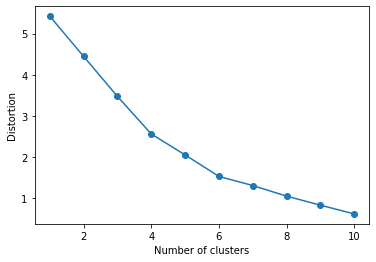

In [159]:
navi_mumbai_grouped_clustering = navi_mumbai_grouped.drop('Neighborhood', 1)
distortions = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i,init='k-means++',n_init=10,max_iter=300,random_state=0)
    kmeans.fit(navi_mumbai_grouped_clustering)
    distortions.append(kmeans.inertia_)
plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

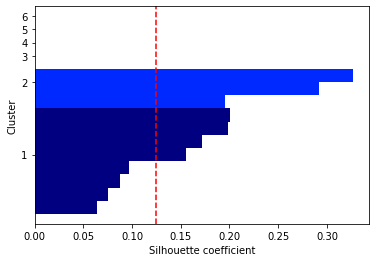

In [160]:
kclusters=6
kmeans = KMeans(n_clusters=kclusters,init='k-means++',n_init=10,max_iter=300,tol=1e-04,random_state=0)
y_kmeans = kmeans.fit_predict(navi_mumbai_grouped_clustering)

import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples
cluster_labels = np.unique(y_kmeans)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(navi_mumbai_grouped_clustering,y_kmeans, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_kmeans == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),c_silhouette_vals,height=1.0, edgecolor='none',color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg,color="red",linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()

we can see that the silhouette coefficient is close to 0 meaning the cluster separation and cohesion are equal

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [161]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

navi_mumbai_merged = navi_mumbai_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
navi_mumbai_merged = navi_mumbai_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

navi_mumbai_merged.head(3)# check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,400614,Navi Mumbai Division,"Belapur Node III S.O,Belapur Node V S.O,Kon...",19.021116,73.038971,0.0,Fast Food Restaurant,Train Station,BBQ Joint,Bed & Breakfast,Bus Station,Indian Restaurant,Department Store,Fish Market,Farmers Market,English Restaurant
1,400701,Navi Mumbai Division,Ghansoli S.O,19.126158,73.001978,0.0,Train Station,Grocery Store,Bus Station,Juice Bar,Vegetarian / Vegan Restaurant,Department Store,Fast Food Restaurant,Farmers Market,English Restaurant,Electronics Store
2,400702,Navi Mumbai Division,"Bokadvira B.O,Chanje B.O,Karanja B.O,Kegaon B....",18.882280,72.949381,3.0,ATM,Food Court,Fish Market,Fast Food Restaurant,Farmers Market,English Restaurant,Electronics Store,Diner,Dessert Shop,Department Store


In [162]:
navi_mumbai_merged = navi_mumbai_merged.dropna()
navi_mumbai_merged['Cluster Labels'] = navi_mumbai_merged['Cluster Labels'].astype('int')

In [163]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(navi_mumbai_merged['Latitude'], navi_mumbai_merged['Longitude'], \
                                  navi_mumbai_merged['Neighborhood'], navi_mumbai_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 7. Examine Clusters

In [164]:
navi_mumbai_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,400614,Navi Mumbai Division,"Belapur Node III S.O,Belapur Node V S.O,Kon...",19.021116,73.038971,0,Fast Food Restaurant,Train Station,BBQ Joint,Bed & Breakfast,Bus Station,Indian Restaurant,Department Store,Fish Market,Farmers Market,English Restaurant
1,400701,Navi Mumbai Division,Ghansoli S.O,19.126158,73.001978,0,Train Station,Grocery Store,Bus Station,Juice Bar,Vegetarian / Vegan Restaurant,Department Store,Fast Food Restaurant,Farmers Market,English Restaurant,Electronics Store
2,400702,Navi Mumbai Division,"Bokadvira B.O,Chanje B.O,Karanja B.O,Kegaon B....",18.882280,72.949381,3,ATM,Food Court,Fish Market,Fast Food Restaurant,Farmers Market,English Restaurant,Electronics Store,Diner,Dessert Shop,Department Store
3,400703,Navi Mumbai Division,"K.U.Bazar S.O,Turbhe Market S.O,Turbhe S.O,Vas...",19.077091,73.000022,0,Vegetarian / Vegan Restaurant,Café,Hotel,Dessert Shop,Indian Restaurant,Cocktail Bar,Middle Eastern Restaurant,Chinese Restaurant,Fast Food Restaurant,Theater
5,400705,Navi Mumbai Division,Sanpada S.O,19.072087,73.004728,1,Indian Restaurant,Fast Food Restaurant,Market,Farmers Market,Smoke Shop,Hotel,Chinese Restaurant,Middle Eastern Restaurant,English Restaurant,Electronics Store


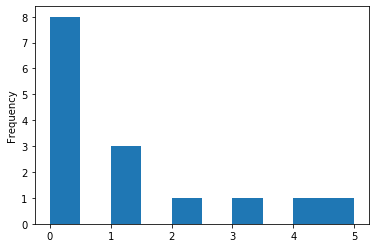

In [165]:
navi_mumbai_merged['Cluster Labels'].plot(kind="hist")

Based on the discriminating venue categories that distinguish each cluster,  we can examine each cluster and assign a name to each cluster.

#### Cluster 0 : 

In [166]:
navi_mumbai_merged.loc[navi_mumbai_merged['Cluster Labels'] == 0, navi_mumbai_merged.columns[[1] + list(range(5, navi_mumbai_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Navi Mumbai Division,0,Fast Food Restaurant,Train Station,BBQ Joint,Bed & Breakfast,Bus Station,Indian Restaurant,Department Store,Fish Market,Farmers Market,English Restaurant
1,Navi Mumbai Division,0,Train Station,Grocery Store,Bus Station,Juice Bar,Vegetarian / Vegan Restaurant,Department Store,Fast Food Restaurant,Farmers Market,English Restaurant,Electronics Store
3,Navi Mumbai Division,0,Vegetarian / Vegan Restaurant,Café,Hotel,Dessert Shop,Indian Restaurant,Cocktail Bar,Middle Eastern Restaurant,Chinese Restaurant,Fast Food Restaurant,Theater
6,Navi Mumbai Division,0,Pizza Place,Café,Vegetarian / Vegan Restaurant,Train Station,English Restaurant,Sandwich Place,Indian Restaurant,Coffee Shop,Farmers Market,Electronics Store
9,Navi Mumbai Division,0,Department Store,Chinese Restaurant,Thai Restaurant,Diner,Lounge,Coffee Shop,Cocktail Bar,Fast Food Restaurant,Farmers Market,English Restaurant
15,Navi Mumbai Division,0,Food Truck,Bus Station,Electronics Store,Department Store,North Indian Restaurant,Movie Theater,Bistro,BBQ Joint,Fast Food Restaurant,Farmers Market
17,Navi Mumbai Division,0,Asian Restaurant,Snack Place,Ice Cream Shop,Flea Market,Vegetarian / Vegan Restaurant,Coffee Shop,Fast Food Restaurant,Farmers Market,English Restaurant,Electronics Store
22,Navi Mumbai Division,0,Toll Plaza,Fish Market,Breakfast Spot,Bus Station,Vegetarian / Vegan Restaurant,Coffee Shop,Fast Food Restaurant,Farmers Market,English Restaurant,Electronics Store


#### Cluster 1 : 

In [167]:
navi_mumbai_merged.loc[navi_mumbai_merged['Cluster Labels'] == 1, navi_mumbai_merged.columns[[1] + list(range(5, navi_mumbai_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Navi Mumbai Division,1,Indian Restaurant,Fast Food Restaurant,Market,Farmers Market,Smoke Shop,Hotel,Chinese Restaurant,Middle Eastern Restaurant,English Restaurant,Electronics Store
10,Navi Mumbai Division,1,Indian Restaurant,Food Court,Hotel,Restaurant,Coffee Shop,Fast Food Restaurant,Farmers Market,English Restaurant,Electronics Store,Diner
20,Navi Mumbai Division,1,Gym,Indian Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,Fast Food Restaurant,Farmers Market,English Restaurant,Electronics Store,Diner,Dessert Shop


#### cluster 2 :

In [168]:
navi_mumbai_merged.loc[navi_mumbai_merged['Cluster Labels'] == 2, navi_mumbai_merged.columns[[1] + list(range(5, navi_mumbai_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,Navi Mumbai Division,2,Flea Market,Mountain,Fish Market,Fast Food Restaurant,Farmers Market,English Restaurant,Electronics Store,Diner,Dessert Shop,Department Store


#### cluster 3 : 

In [169]:
navi_mumbai_merged.loc[navi_mumbai_merged['Cluster Labels'] == 3, navi_mumbai_merged.columns[[1] + list(range(5, navi_mumbai_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Navi Mumbai Division,3,ATM,Food Court,Fish Market,Fast Food Restaurant,Farmers Market,English Restaurant,Electronics Store,Diner,Dessert Shop,Department Store


#### cluster 4 : 

In [170]:
navi_mumbai_merged.loc[navi_mumbai_merged['Cluster Labels'] == 4, navi_mumbai_merged.columns[[1] + list(range(5, navi_mumbai_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Navi Mumbai Division,4,Bistro,Vegetarian / Vegan Restaurant,Coffee Shop,Fish Market,Fast Food Restaurant,Farmers Market,English Restaurant,Electronics Store,Diner,Dessert Shop


#### cluster 5: 

In [171]:
navi_mumbai_merged.loc[navi_mumbai_merged['Cluster Labels'] == 5, navi_mumbai_merged.columns[[1] + list(range(5, navi_mumbai_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Navi Mumbai Division,5,Hotel,Vegetarian / Vegan Restaurant,Coffee Shop,Fish Market,Fast Food Restaurant,Farmers Market,English Restaurant,Electronics Store,Diner,Dessert Shop
